# Principal Component Analysis (PCA): Global 1854-2023 sea surface temperature

## Sea Surface Temperature (SST) data

In this notebook, we will analyze global SST data over the time period 1854-2023. The data has a horizontal resolution of $2^{\circ} \times 2^{\circ}$. This exercise will allow us to see how PCA can be used to identify and analyze important climate patterns, such as global warming and different modes of climate variability.

We use the ERSTTv5 data set from the National Oceanic and Atmospheric Administration (NOAA). It is openly available:<br> https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html


## Details about the modified PCA procedure (optional)

In the notebook tday_sl_bs_jj.ipynb, there is a recap on the mathematical notions of PCA that we covered in class. However, due to the particularities of the ERSTTv5 data set, we need to use a slightly different method to perform PCA.

In our previous notebook, we had daily data at 3 stations (Seoul, Busan, Jeju). Thus, we had much more data samples ($n=25567$ days) than variables ($k=3$ stations). Instead here, we will analyze yearly SST data over the entire globe. The dimensionality of this data set is therefore $n=170$ years and $k=10176$ grid points. Now, we have much more variables than data samples. If we proceed as before, by computing the empirical covariance matrix $S$ of the centered data $\tilde{X}$ (dimensions $n \times k$):

$\begin{equation}
S = \frac{1}{n-1} \tilde{X}^{T}\tilde{X}
\end{equation}$,

then, $S$ would be of size $k \times k = 10176 \times 10176$. This matrix is too large to perform its eigedecomposition, which requires some computations that are numerically costly. Instead, we use the singular value decomposition (SVD) of $\tilde{X}$. The SVD method for PCA is not part of this class. I provide here some basic mathematical principles of this method, but without covering all the details. For a more comprehensive overview of this method, the interested reader is referred to the reference textbooks.

In SVD, we decompose the matrix $\tilde{X}$ as:

$\begin{equation}
\tilde{X} = L \Sigma R^{T}
\end{equation}$,

where $L$ ($n \times n$) and $R$ ($k \times k$) are othonormal matrices. The matrix $\Sigma$ ($n \times k$) has entries $\sigma_{i}$ on its main diagonal, and 0 elsewhere. The $\sigma_{i}$ values are called singular values, the columns of $L$ are called left singular vectors, and the columns of $R$ are called right singular vectors. There are at most min($n,k$) non-zero singular values.

The columns of $R$ corresponding to the non-zero singular values are the eigenvectors. That is, they are the same as the eigenvectors of $S$. We can prove this in one line of linear algebra. First remember that $V$ is the matrix of eigenvectors of $S$, and $\Lambda$ the diagonal matrix of its eigenvalues. We have:

$\begin{equation}
S = V \Lambda V^{T}
\end{equation}$.

Thus, using the properties of orthonormal matrices:

$\begin{equation}
S = \frac{1}{n-1} \tilde{X}^{T}\tilde{X} = \frac{1}{n-1} (L \Sigma R^{T})^{T} (L \Sigma R^{T}) = \frac{1}{n-1} R \Sigma^{T} L^{T} L \Sigma R^{T} = \frac{1}{n-1} R \Sigma^{T} \Sigma R^{T}
\end{equation}$.

Note that $\Sigma^{T} \Sigma$ gives a diagonal matrix with entries $\sigma_{i}^{2}$. It is clear that we have $R=V$, and the eigenvalues $\lambda_{i} = \frac{1}{n-1} \sigma_{i}^{2}$, where the term $\frac{1}{n-1}$ is just a constant scaling factor for the eigenvalues. In conclusion, we can compute the SVD of $\tilde{X}$, we collect the eigenvectors as the columns of $R$ and the eigenvalues as the squared entries of $\Sigma$. We find the PC coefficients as before, by projecting $\tilde{X}$ on the eigenvectors:

$\begin{equation}
A = \tilde{X}V
\end{equation}$

where the matrix A is of dimensions $n\times k$, and it has the PC coefficient time series as its columns.


## PCA to analyze SST variability

As mentioned above, we will analyze yearly (1854-2023) SST data over the entire globe. We have 170 years, and 10176 grid cells. Thus:

$\begin{equation}
\left\{ 
  \begin{aligned}
    &k=10176 \\
    &n=170
  \end{aligned}
\right.
\end{equation}$

You will note that, in this exercise, we will discard land grid cells, as well as sea-ice covered grid cells. 

We start by importing some python packages needed for the analysis. We also import some functions stored in a separate code file.

In [1]:
import os
import sys
import csv
import copy
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
from procfuncs import yearlymean_frommonthly
from procfuncs import smooth_movingaverage_time

We specify the file name, as well as some parameters. And we load the data.

In [2]:
### File to load ###
floc_ersst = 'ersstv5_sst_yearly_1854to2023_2deg.nc'

### Some operators ###
lg_a = np.logical_and

### Parameters ###
limsdev_seaice  = 0.01 #[K] minimum inter-annual variability standard deviation not to be considered sea-ice

### Constants ###
deg_per_rad  = 360/(2*np.pi)

### Load ERSST ###
ds      = nc.Dataset(floc_ersst)
tm_yr            = np.array(ds['time'])
gridlat          = np.array(ds['lat'])
gridlon          = np.array(ds['lon'])
valsgr_ersst_yr  = np.array(ds['sst'])
ds.close()
valsgr_ersst_yr[valsgr_ersst_yr<1e-30] = np.nan #masking out land grid cells
n_yr     = len(tm_yr) #number of years
nny,nnx  = np.shape(gridlat) #number of grid cells in latitudinal and longitudinal directions 

Now, we define two additional functions. The first function is to perform PCA from a 2-dimensional (time $\times$ space) field using the SVD method. The second function is just a plotting routine that will be useful to look at the results later on.

In [3]:
def pca_from2d(field):
     '''
     Performs PCA on two-dimensional field: time x space
     Returns: eigenvalues, eigenvectors, coefficients
     '''
     nn_t,nn_x  = np.shape(field)
     mmu        = np.nanmean(field,axis=0)
     matx       = field-mmu[np.newaxis,:] #time series anomalies
     bigu,svec,bigvt = np.linalg.svd(matx,full_matrices=False)
     llambdas        = svec**2
     ceigvcs0        = np.copy(bigvt.T)
     isort           = np.flip(np.argsort(llambdas))
     llambdas        = llambdas[isort]
     ceigvcs0        = ceigvcs0[:,isort]
     # Rescale eigenvectors to unit length #
     ceigvcs         = ceigvcs0/(np.sqrt(np.sum(ceigvcs0**2,axis=0)[np.newaxis,:]))
     cpccfs          = (matx @ ceigvcs) #project
     return(llambdas,ceigvcs,cpccfs)
 
def plot_eigvec_pc(in_eigvec,in_pc,number=''):
    '''
    Plotting routine to show global map of an eigenvector,
    and its coefficient time series
    '''
    srplot          = np.copy(in_pc)
    temp            = np.copy(in_eigvec)
    temp            = (temp-np.mean(temp))/np.std(temp)
    fieldplot       = np.nan*np.ones((nny,nnx))
    fieldplot[mkin] = np.copy(temp)
    lsposax = [[0.01,0.42,0.84,0.57],[0.10,0.08,0.88,0.30]]
    poscax  = [0.86,0.44,0.015,0.53]
    pl_levs  = np.linspace(-3,3,101)
    pl_ticks = np.round(np.linspace(np.min(pl_levs),np.max(pl_levs),5),1)
    fig = plt.figure(figsize=(8.5,6.4))
    ax  = plt.subplot(211)
    ax.set_position(lsposax[0])
    mycmap = plt.cm.jet
    mymap = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c')
    mymap.drawcoastlines(),mymap.fillcontinents(color='w'),mymap.drawmapboundary(fill_color='w')
    contourplot = ax.contourf(gridlon,gridlat,fieldplot,levels=np.linspace(-3,3,101),cmap=mycmap,extend='both')
    cax = fig.add_axes(poscax)
    cbar = plt.colorbar(contourplot,cax=cax,orientation='vertical')
    cbar.set_ticks(pl_ticks)
    cbar.set_ticklabels(pl_ticks,fontsize=14)
    cbar.ax.set_ylabel(f'standardized eigenvector {number}',size=15,rotation=-90,labelpad=20)
    ax = plt.subplot(212)
    ax.set_position(lsposax[1])
    ax.plot(tm_yr,srplot,c='k',linewidth=1.5)
    ax.tick_params(which='major',axis='both',labelsize=13)
    ax.set_ylabel(f'PC {number} score',fontsize=14)
    

Now, we mask our data set. That is, we discard the land and sea-ice grid cells. Note that we convert the spatial dimension of the data from gridded latitude-longitude to a single spatial dimension, so that we can have our data in a matrix of dimensions time $\times$ space (variable vals_ersst_m in the code). We also average the monthly data to a yearly time scale (variable vals_ersst_yr). 

In [4]:
### Get mask of data ###
mkin = lg_a(np.isnan(valsgr_ersst_yr[0,:,:])==False,np.nanstd(valsgr_ersst_yr,axis=0)>=limsdev_seaice)
n_mkin         = np.sum(mkin)
vlats          = gridlat[mkin]
vlons          = gridlon[mkin]
vals_ersst_yr  = valsgr_ersst_yr[:,mkin] #convert from gridded values to 1d in space


/Users/vverjans/anaconda3/envs/FirstEnvi/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


We are interested in analyzing the modes and patterns of variability in the data. However, SSTs have been strongly influenced by the global warming trend caused by the anthropogenic greenhouse gas forcing. One common method to circumvent this problem is to remove the global mean SST at each time step from the data. This is not equivalent to centering required for PCA. Centering implies removing the mean taken across time steps. Here, we remove the mean taken across grid points. The objective of this operation is only to remove the mean global warming signal from our data set. The resulting matrix is called vals_ersst_rmg_yr in the code.

In [5]:
### Remove global mean SST at each time step ###
globmn_ersst_yr   = np.mean(vals_ersst_yr,axis=1) #mean across grid points
vals_ersst_rmg_yr = vals_ersst_yr-globmn_ersst_yr[:,np.newaxis] #(this approximately removes the mean warming trend)

The grid of our data set has a regular $2^{\circ} \times 2^{\circ}$ resolution. Due to the shape of the Earth surface, this implies that grid cells at high latitudes have a smaller area than grid cells at lower latitudes. For this reason, we need to give lower weight to high-latitude grid cells, because otherwise PCA would overestimate their contribution to the global variability in SST. A simple weighting scheme is to multiply the values by the cosine of their latitude.

And finally, we center our data by removing the mean values taken across time steps. That is, we form our $\tilde{X}$ matrix. The latitude-weighted $\tilde{X}$ matrix is called wctr_ersst_rmg_yr in the code. 

In [6]:
### Weights according to latitude ###
temp  = np.cos(vlats/deg_per_rad)
w_lat = temp/np.sum(temp)

### Center values ###
mns_ersst_rmg_yr   = np.mean(vals_ersst_rmg_yr,axis=0) #mean across time steps
ctr_ersst_rmg_yr   = vals_ersst_rmg_yr-mns_ersst_rmg_yr[np.newaxis,:] #centering
wctr_ersst_rmg_yr  = w_lat[np.newaxis,:]*ctr_ersst_rmg_yr #weighting
dimn,dimk          = np.shape(wctr_ersst_rmg_yr) #data dimensions

Now, we can perform PCA using the function defined above. Notice that we use wctr_ersst_rmg_yr directly, and we do not need to compute the empirical covariance matrix.

In [7]:
### Perform PCA ###
eigvals,ceigvecs,cpccfs = pca_from2d(wctr_ersst_rmg_yr)

Let's look at the first 50 eigenvalues.

[0.22 0.3  0.36 0.4  0.45 0.48 0.51 0.54 0.57 0.59 0.61 0.63 0.65 0.66
 0.68 0.69 0.7  0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.8  0.81
 0.82 0.82 0.83 0.84 0.84 0.85 0.85 0.86 0.87 0.87 0.87 0.88 0.88 0.89
 0.89 0.9  0.9  0.9  0.91 0.91 0.91 0.92]


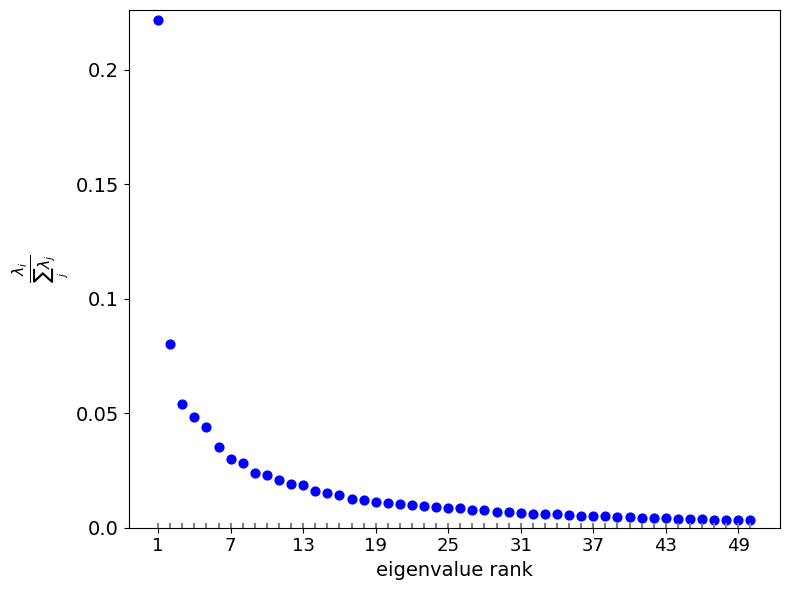

In [8]:
### Figure: eigenvalues ###
pl_num = 50
pltemp = eigvals[0:pl_num]/np.sum(eigvals)
fig = plt.figure(figsize=[8,6])
ax = plt.subplot(111)
ax.scatter(np.arange(1,pl_num+1,1),pltemp,c='b',marker='o',s=2000/pl_num)
ax.scatter(np.arange(1,pl_num+1,1),np.zeros(pl_num),c='grey',marker='|',s=50)
ax.set_ylim([0,1.02*np.max(pltemp)])
ax.set_xlabel('eigenvalue rank',fontsize=14)
ax.set_ylabel(r'$\frac{\lambda_{i}}{\sum_{j}\lambda_{j}}$',fontsize=16)
ax.set_yticks(np.arange(0,np.max(pltemp),0.05),labels=np.round(np.arange(0,np.max(pltemp),0.05),2),fontsize=14)
ax.set_xticks(np.arange(1,pl_num+1,int(pl_num/8)),labels=np.arange(1,pl_num+1,int(pl_num/8)),fontsize=13)
fig.tight_layout()
print(np.round(np.cumsum(eigvals[0:pl_num])/np.sum(eigvals),2))

The first 7 eigenvectors explain more than 50% of the variability. The first 27 eigenvectors explain more than 80% of the variability. So, clearly, our coordinate space spanning 10176 grid cells can be reduced efficiently.

Now, we analyze the first eigenvector and its coefficient time series.

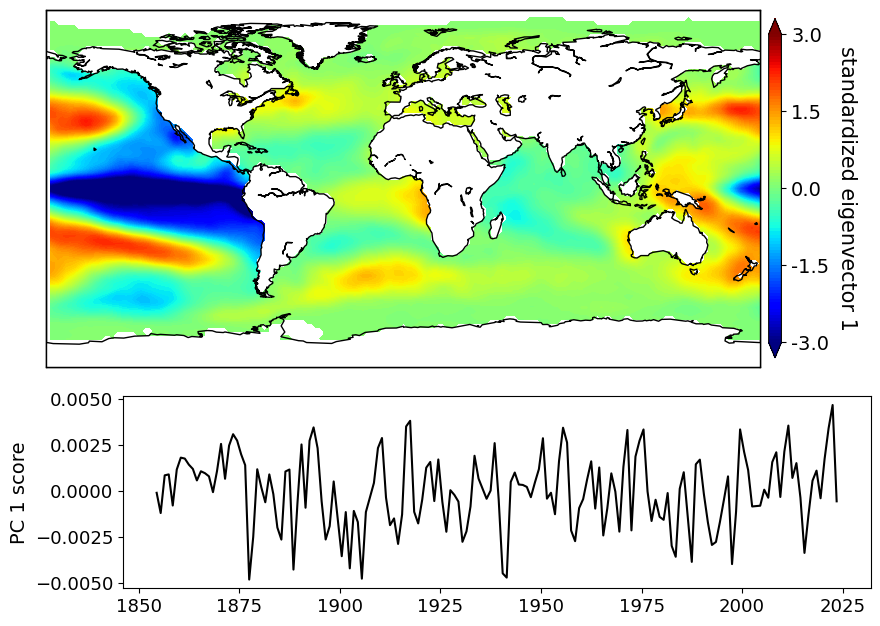

In [9]:
### Figure: first eigenvector ###
plot_eigvec_pc(ceigvecs[:,0],cpccfs[:,0],number=1)

The first eigenvector shows a strong signal spanning from the Eastern Pacific to the Western Pacific. This is the signature pattern of the El Nino Southern Oscillation (ENSO). ENSO has an irregular periodicity, typically ranging between 2-7 years. The PC time series allows us to identify some of the recent strong El Nino events: 1992, 1997, and 2015. Note that the they appear as negative anomalies here. This is arbitrary, as an eigenvector can be multiplied by -1, while still showing the same pattern of variability. We can also identify some recent strong La Nina events: 2011 and 2022. Notice also that the magnitude of such peaks in the PC1 coefficient appears to remain approximately constant throughout the time series.

Now is good point to caution about an important limitation in the interpretation of PCA results. PCA is a purely mathematical technique, with no physical constraint. Thus, PCA shows us patterns where variability in the data is maximal. This implies that several modes of climate variability can be mixed together! For example, in this PC1, we also see a relatively strong signal in the North-Pacific, which is likely associated with the Pacific Decadal Oscillation (PDO). While the PDO is somewhat associated with ENSO, it is also influenced by other mechanisms, which are to some degree mixed with the ENSO signal in PC1. One should always keep in mind such limitations when trying to interpret the results of PCA. For those of you who are interested in this aspect, you are encouraged to study some methods that aim to overcome this limitation, such as Rotated Empirical Orthogonal Functions.

Similarly to PC1, we can look at PC2.

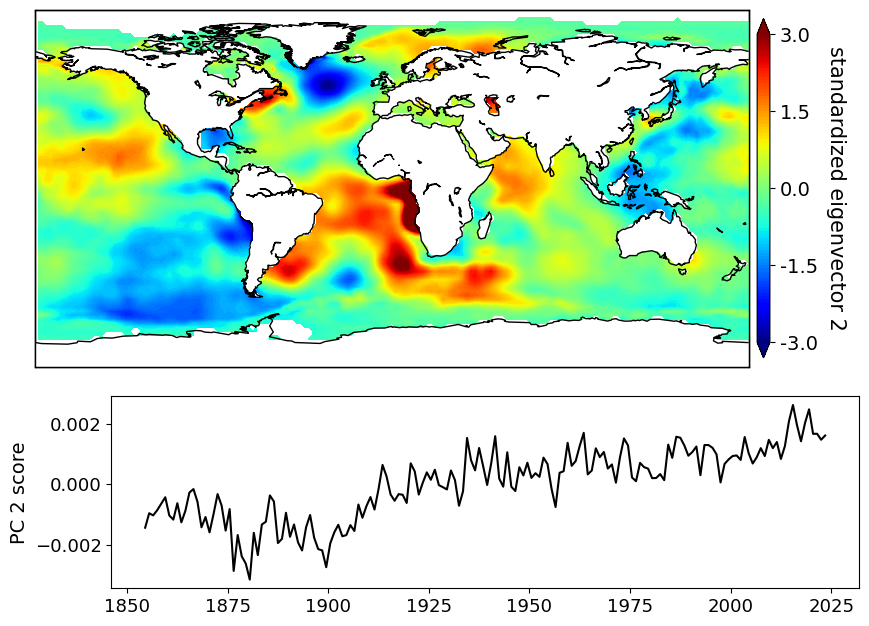

In [10]:
### Figure: second eigenvector ###
plot_eigvec_pc(ceigvecs[:,1],cpccfs[:,1],number=2)

The PC2 time series shows an increase over time. Since we have removed the global mean temperature signal, this indicates that some regions are warming faster/slower than the global mean. These regions are highlighted by the PC2. For example, the North-Atlantic warming hole stands out. This is a region where warming is much slower than the global mean. On the other hand, it seems that the South-Atlantic and parts of the Indian and Arctic oceans are warming faster than average.

Let's look at PC3.

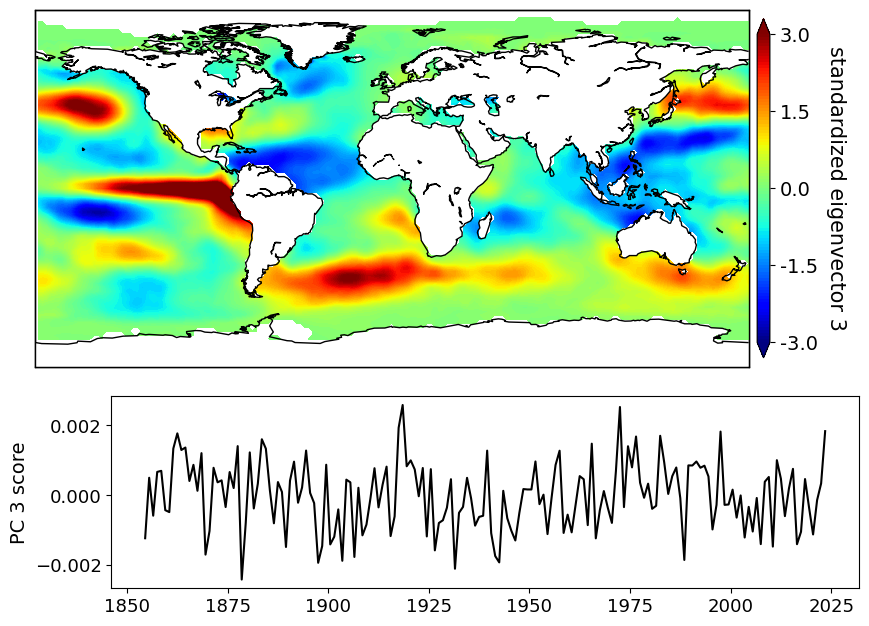

In [11]:
### Figure: third eigenvector ###
plot_eigvec_pc(ceigvecs[:,2],cpccfs[:,2],number=3)

The pattern of PC3 confirms the caution about physical interpretability that we made above. Here again, we see a strong signal in the Pacific, which probably indicates some mixing of physical mechanisms with PC1. However, we find here more teleconnection signals with the Atlantic. That is, modes of variability where the Pacific and the Atlantic co-vary. Interpreting the PC time series is more complicated though, because it represents residual variability not captured by PC1 and PC2. Analyzing teleconnections between Pacific and Atlantic specifically would therefore likely require some more data processing prior to performing PCA. 

We just looked at the first 3 PCs. What if we look at the last PC? That is, the eigenvector with the smallest eigenvalues.

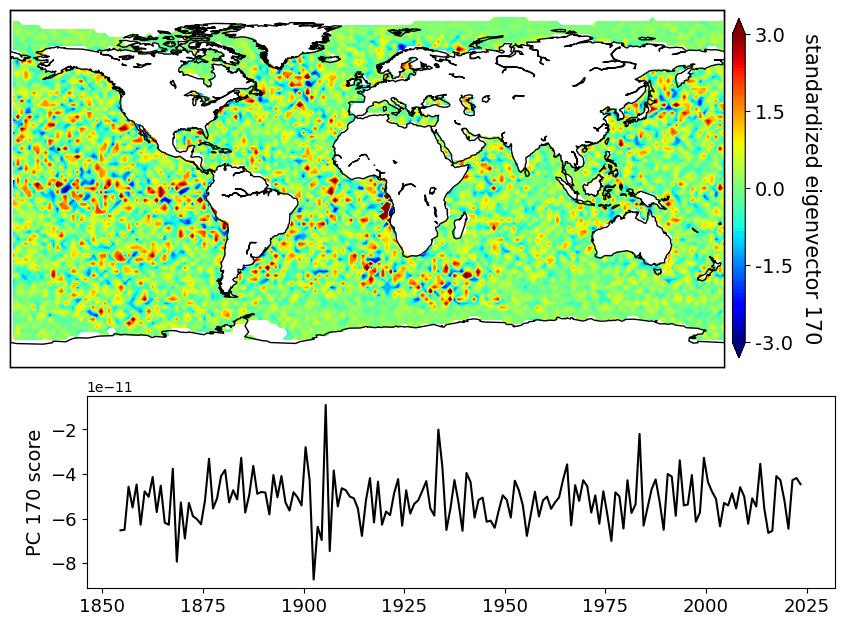

In [12]:
### Figure: last eigenvector ###
plot_eigvec_pc(ceigvecs[:,-1],cpccfs[:,-1],number=dimn)

Clearly, this eigenvector only represent noise. This is expected, because it captures only a very small fraction of the variability (it has a very small eigenvalue).

## PCA to anlayze longer-term variability

For some applications, one could be more interested in longer-term variability. That is, we may want to remove high-frequency variability, such as year-to-year variability, or even the 3-7 year ENSO variability. To do so, we can smooth the SST anomaly (i.e., the centered SST) data with a running mean filter. Here, I do so with a 10-year running mean.

In [13]:
### Decadal smoothing ###
smwindow                = 10
ctr_ersst_rmg_sm10_yr   = smooth_movingaverage_time(tm_yr,ctr_ersst_rmg_yr,window=smwindow,axis_time=0,set_nans=False)
wctr_ersst_rmg_sm10_yr  = w_lat[np.newaxis,:]*ctr_ersst_rmg_sm10_yr

### Perform PCA ###
eigvals_sm10,ceigvecs_sm10,cpccfs_sm10 = pca_from2d(wctr_ersst_rmg_sm10_yr)

We can look at the first PC of the smoothed data.

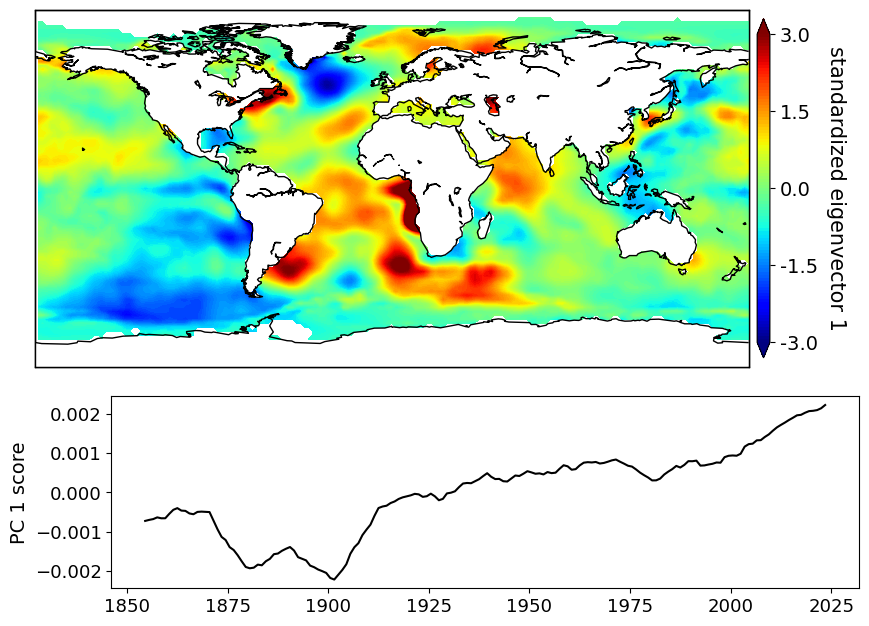

In [14]:
### Figure: first eigenvector ###
plot_eigvec_pc(ceigvecs_sm10[:,0],cpccfs_sm10[:,0],number=1)

We find the same pattern as the one for PC2 of the yearly data. This is not surprising. We found that this PC shows the warming patterns relative to the mean global warming. So, it makes sense that this pattern appears as well when analyzing decadal variability. Both the PC itself and the PC time series agree well with PC2 of yearly values shown above, except that the time series is smoothed.

Let's look at PC2 of the 10-year smoothed data.

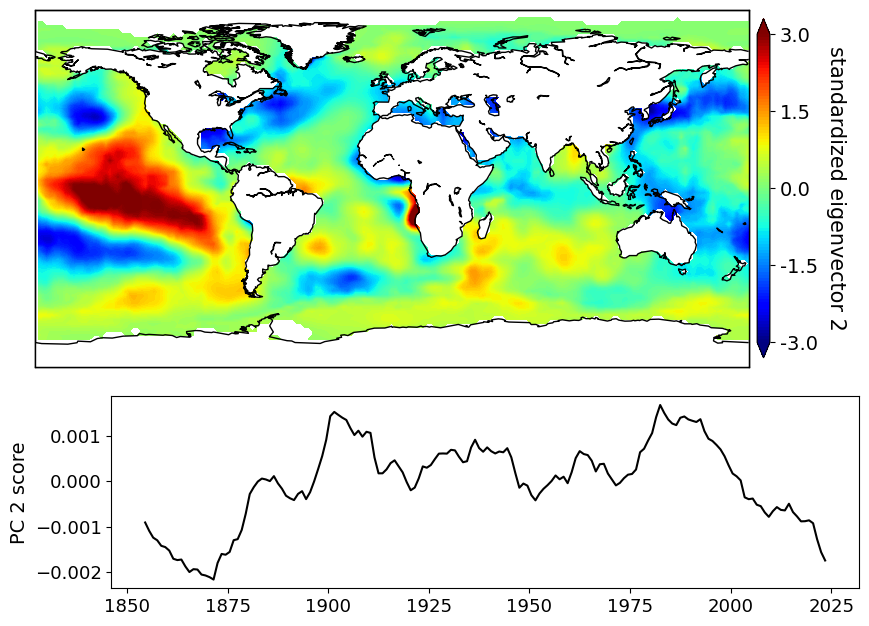

In [15]:
### Figure: second eigenvector ###
plot_eigvec_pc(ceigvecs_sm10[:,1],cpccfs_sm10[:,1],number=2)

The main pattern is in the Pacific. We can see the typical tri-pole pattern of the Interdecadal Pacific Oscillation (IPO). That is: opposing SST signals in the Equatorial Pacific compared to the Norht-West and South-West Pacific. The IPO was in a so-called positive phase in the 1980's. It shifted to a negative phase during the 2000's. However, the IPO moved back towards a positive phase in the 2010's, which is not shown by our PC time series. Again, this may stem from mixing variability components between different PCs.

Finally, let's look at the third PC of the 10-year smoothed data.

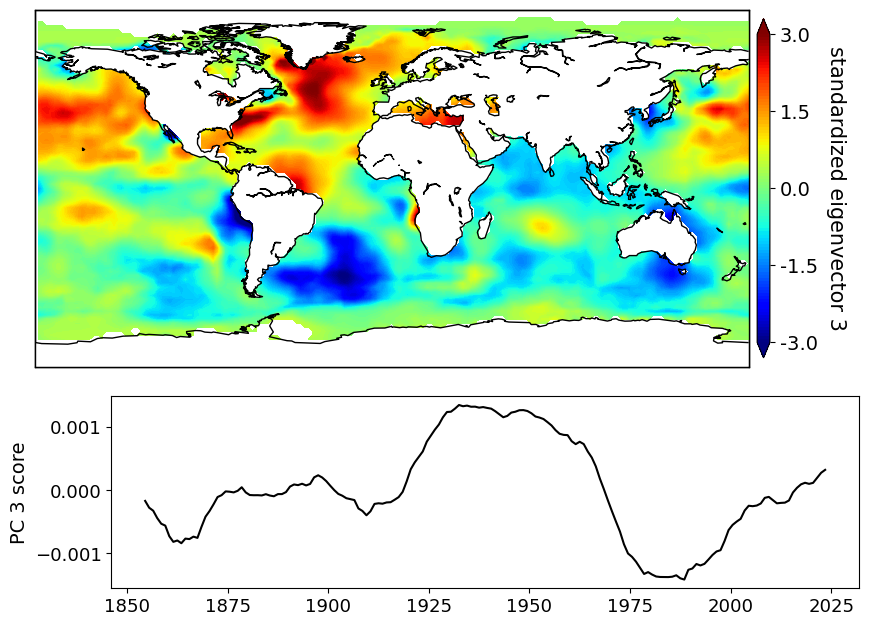

In [16]:
### Figure: third eigenvector ###
plot_eigvec_pc(ceigvecs_sm10[:,2],cpccfs_sm10[:,2],number=3)

The overarching pattern here is a di-pole structure in the Atlantic: North-Atlantic versus South-Atlantic. This is another well-known mode of climate variability: the Atlantic Multi-decadal Oscillation (AMO). The AMO was very positive (i.e., warmer in the North) during the 1925-1965 period, and very negative during the 1975-1995 period. Our PC3 time series seems to show the termination of this negative phase slightly too early. We are currently in a positive phase of the AMO, but of reltively low magnitude.

I hope that you enjoyed this introduction to principal component analysis for climate sciences. This is a powerful technique for analyzing a lot of different climate-related data sets. I hope that you will consider using it in the future, and you can also explore more advanced techniques that build upon PCA.